# A/B Hypothesis Testing Demo

This notebook demonstrates the `ABHypothesisTester` module for insurance data analysis.
We will test the following null hypotheses:
1. **Risk across Provinces**: H0: No risk differences across provinces.
2. **Risk across Zip Codes**: H0: No risk differences between zip codes.
3. **Margin across Zip Codes**: H0: No margin difference between zip codes.
4. **Risk by Gender**: H0: No risk difference between Women and Men.

In [1]:
import pandas as pd
import sys
import os

# Add scripts to path
sys.path.append(os.path.abspath(os.path.join('..', 'scripts')))

from ab_hypothesis_testing import ABHypothesisTester
from clean_data import DataCleaner

## 1. Load Data

In [2]:
# Load Data
clean_data_path = "../data/MachineLearningRating_v3_cleaned.csv"
raw_data_path = "../data/MachineLearningRating_v3.txt"

if os.path.exists(clean_data_path):
    print(f"Loading cleaned data from {clean_data_path}...")
    import pandas as pd
    # Parse dates explicitly for consistency
    df = pd.read_csv(clean_data_path, parse_dates=['TransactionMonth', 'VehicleIntroDate'], low_memory=False)
    print("✓ Loaded cleaned data.")
else:
    print(f"Cleaned data not found. Processing raw file from {raw_data_path}...")
    cleaner = DataCleaner()
    # Save to cleaned so next time it loads faster
    df = cleaner.process_file(raw_data_path, save_to_cleaned=True)

print(f"Loaded data with {df.shape} shape.")

Loading cleaned data from ../data/MachineLearningRating_v3_cleaned.csv...
✓ Loaded cleaned data.
Loaded data with (1000024, 51) shape.


## 2. Inspect Columns (Find Zip Code)

In [3]:
print("Columns:", df.columns.tolist())

# Check for likely Zip Code columns
potential_zip = [c for c in df.columns if 'postal' in c.lower() or 'zip' in c.lower() or 'code' in c.lower()]
print("Potential Zip Code columns:", potential_zip)

# Set variables for columns based on inspection
ZIP_COL = "PostalCode" if "PostalCode" in df.columns else potential_zip[0] if potential_zip else None
GENDER_COL = "Gender"
PROVINCE_COL = "Province"

print(f"\nUsing columns:\nZip: {ZIP_COL}\nGender: {GENDER_COL}\nProvince: {PROVINCE_COL}")

Columns: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium', 'TotalClaims', 'TransactionYear', 'VehicleAge', 'LossRatio']
Potential Zip Code columns: ['PostalCode', 'mmcode']

Using columns:
Zip: PostalCode
Gender: Gender
Province: Province


In [4]:
# Initialize Tester
tester = ABHypothesisTester(df)

## 3. Hypothesis Testing

### H1: Risk Differences across Provinces


--- Testing Risk Differences: Gauteng vs Western Cape ---


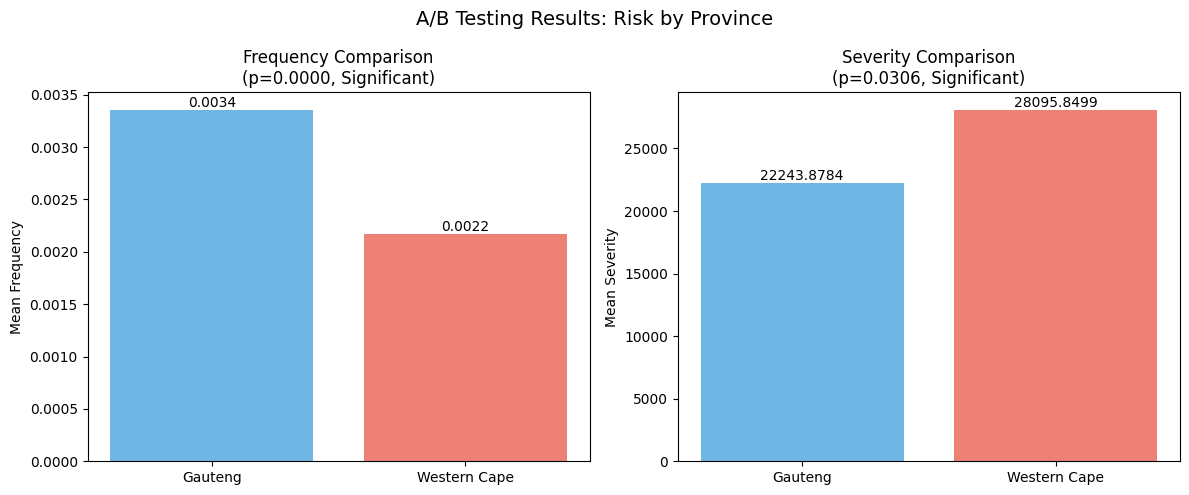

{'Frequency_Test': {'TestType': 'Chi-Squared',
  'Statistic': np.float64(55.98300888610175),
  'P-Value': np.float64(7.310004984273572e-14),
  'Significant': np.True_,
  'GroupA_Mean': np.float64(0.0033565141001520842),
  'GroupB_Mean': np.float64(0.0021672153040544497)},
 'Severity_Test': {'TestType': 'T-Test (Welch)',
  'Statistic': np.float64(-2.1685349701517818),
  'P-Value': np.float64(0.0305989604929201),
  'Significant': np.True_,
  'GroupA_Mean': np.float64(22243.878395705604),
  'GroupB_Mean': np.float64(28095.84988051209)}}

In [5]:
# Pick top 2 provinces by size
top_provinces = df[PROVINCE_COL].value_counts().head(2).index.tolist()
if len(top_provinces) >= 2:
    res_prov = tester.test_risk_provinces(top_provinces[0], top_provinces[1])
    display(res_prov)
else:
    print("Not enough provinces found.")

### H2 & H3: Risk and Margin Differences between Zip Codes

Testing Zip Codes: [2000, 122]

--- Testing Risk Differences: Zip 2000 vs 122 ---


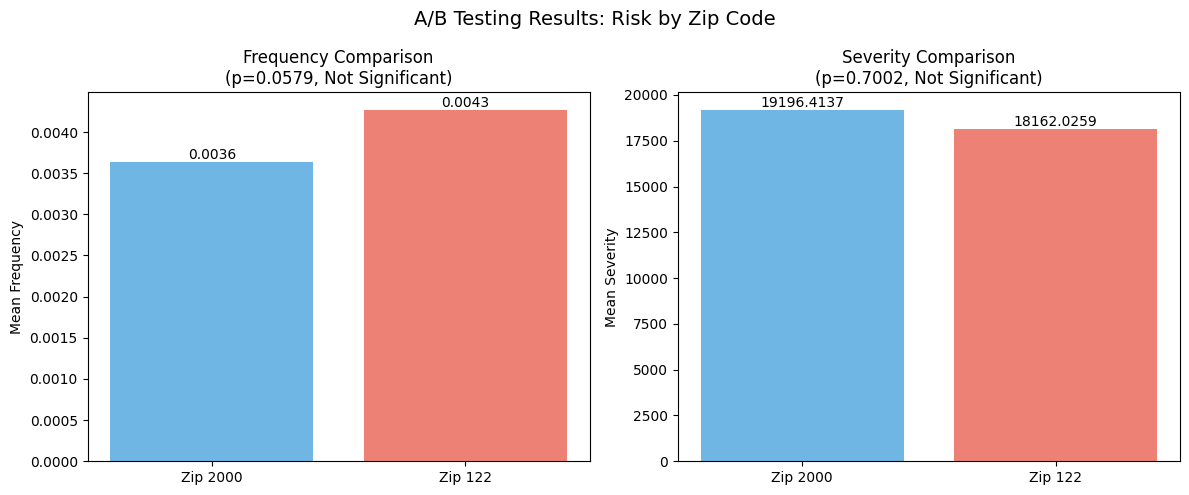

{'Frequency_Test': {'TestType': 'Chi-Squared',
  'Statistic': np.float64(3.597050712428362),
  'P-Value': np.float64(0.05788217295685014),
  'Significant': np.False_,
  'GroupA_Mean': np.float64(0.003640503977587679),
  'GroupB_Mean': np.float64(0.004270810030302414)},
 'Severity_Test': {'TestType': 'T-Test (Welch)',
  'Statistic': np.float64(0.38537639993700307),
  'P-Value': np.float64(0.7002080007323607),
  'Significant': np.False_,
  'GroupA_Mean': np.float64(19196.413726806724),
  'GroupB_Mean': np.float64(18162.025865497075)}}


--- Testing Margin Differences: Zip 2000 vs 122 ---


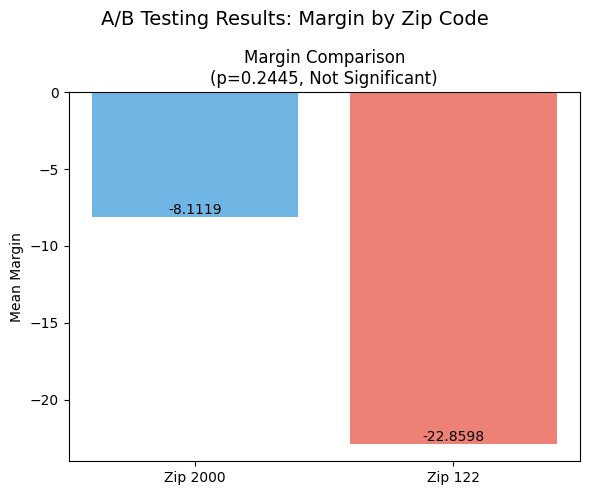

{'Margin_Test': {'TestType': 'T-Test (Welch)',
  'Statistic': np.float64(1.1639145988804174),
  'P-Value': np.float64(0.24446241842452016),
  'Significant': np.False_,
  'GroupA_Mean': np.float64(-8.111944272270652),
  'GroupB_Mean': np.float64(-22.859806159734156)}}

In [6]:
# Pick top 2 zip codes by size
if ZIP_COL:
    top_zips = df[ZIP_COL].value_counts().head(2).index.tolist()
    print(f"Testing Zip Codes: {top_zips}")
    
    if len(top_zips) >= 2:
        # H2: Risk
        res_zip_risk = tester.test_risk_zipcodes(ZIP_COL, top_zips[0], top_zips[1])
        display(res_zip_risk)
        
        # H3: Margin
        res_zip_margin = tester.test_margin_zipcodes(ZIP_COL, top_zips[0], top_zips[1])
        display(res_zip_margin)
    else:
        print("Not enough zip codes found.")
else:
    print("Zip Code column not identified.")

### H4: Risk Difference between Women and Men

In [ ]:
unique_genders = df[GENDER_COL].unique()
print("Unique Genders:", unique_genders)

# Adjust values if needed based on print output (e.g. 'Male', 'Female' vs 'M', 'F')
res_gender = tester.test_risk_gender(GENDER_COL, "Female", "Male")
display(res_gender)

gender column dropped due to missing values